In [1]:
#Install list of libraries
# %pip install imbalanced-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install scikit-learn
# %pip install scipy
# %pip install seaborn --upgrade

In [2]:
#In case you want to reload the modules automatically (imports aren't cached properly)
# %load_ext autoreload
# %autoreload 2

In [3]:
from os import path, getcwd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.io import loadmat
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

subjects = [102, 104, 105, 107, 109, 110, 111, 115, 116, 117, 118, 120, 126, 127, 130, 131, 132, 133, 135, 138, 141, 143, 144]
col = ['1','2','3','Label', 'Frontal P3 mean', 'Frontal P3 STD', 'Posterior P3 mean', 'Posterior P3 STD', 'Frontal alpha mean', 
           'Posterior alpha mean', 'Alpha variability', 'Reaction time Mean', 'Reaction time variability', 'Accuracy', 'Frontal P3 log energy entropy', 
           'Frontal P3 Shannon entropy', 'Frontal P3 SURE entropy', 'Frontal P3 Skewness', 'Frontal P3 Kurtosis', 'Frontal alpha log energy entropy',
           'Frontal alpha Shannon entropy', 'Frontal alpha SURE entropy', 'Frontal alpha Skewness', 'Frontal alpha Kurtosis', 
           'Posterior P3 log energy entropy', 'Posterior P3 Shannon entropy', 'Posterior P3 SURE entropy', 'Posterior P3 Skewness', 'Posterior P3 Kurtosis', 
           'Posterior alpha log energy entropy', 'Posterior alpha Shannon entropy', 'Posterior alpha SURE entropy', 'Posterior alpha Skewness',
           'Posterior alpha Kurtosis'
]
cwd = getcwd()
target_names = ['Task Unrelated Thought', 'Task Related Thought']

# Data Collection
Loading mat files into dataframe and removing unnecessary columns. NaN values are replaced with 0. 

Should any extra subjects be re-included in the future, their .mat file should be copied into 'AIRES_project/TR and TUT data', and their subject number added to the list of subjects.

In [4]:
#Load all subject mat files, append TR and TUR structures to dataframe
for a in subjects:
    file = 'Feature_data_'+str(a)+'.mat'
    #Absolute path to mat file:
    #loc = os.path.join('C:/Users/pisis/OneDrive - University of Calgary/2024/AIRS/TR and TUT data',file)
    loc = path.join(cwd, 'TR and TUT data', file)
    subData = loadmat(loc)['data']
    subDataTR = subData['TR'][0,0]
    subDataTUR = subData['TUR'][0,0]
    subDFTR = pd.DataFrame(subDataTR, columns = col)
    subDFTUR = pd.DataFrame(subDataTUR, columns = col)
    if a==subjects[0]:
        totalDF = pd.concat([subDFTR,subDFTUR])
    else:
        totalDF = pd.concat([totalDF, subDFTR])
        totalDF = pd.concat([totalDF, subDFTUR])
print(totalDF)

#Show Data with NaN values:
# print(totalDF[totalDF.isnull().any(axis=1)])
# NOTE: Subject 109 has NaN values in the Reaction time Mean and Reaction time variability columns. Will fill with 0-values, may need to exclude
totalDF.fillna(0, inplace=True)

targetData = totalDF.iloc[:,3:]
# print(targetData)
X = targetData.iloc[:,1:]
Y = targetData.Label
Y = Y - 1
# Verify that Labels contain only 1 and 2:
# print(targetData.Label.unique())



        1     2    3  Label  Frontal P3 mean  Frontal P3 STD  \
0   102.0   8.0  4.0    1.0        -4.473627        0.576930   
1   102.0  25.0  5.0    1.0        -1.786179        0.747948   
2   102.0  30.0  5.0    1.0         2.321102        0.274870   
3   102.0  32.0  4.0    1.0        -2.569933        0.658272   
0   102.0   1.0  5.0    2.0         2.814653        0.359229   
..    ...   ...  ...    ...              ...             ...   
19  144.0  30.0  3.0    2.0         0.375386        0.774057   
20  144.0  31.0  3.0    2.0         0.482558        2.200203   
21  144.0  32.0  3.0    2.0        -0.893606        0.333826   
22  144.0  34.0  3.0    2.0        -1.408621        0.136761   
23  144.0  35.0  1.0    2.0        -2.785345        0.359457   

    Posterior P3 mean  Posterior P3 STD  Frontal alpha mean  \
0            0.511275          0.849015            0.424295   
1            1.117962          0.297814            2.976309   
2           -0.140859          0.650573   

# PreProcessing: Split and Normalize

Using the built-in normalize, alternatives: StandardScaler, MinMaxScaler

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


normalized_X_train = normalize(X_train)


# SMOTE Data Augmentation
Data is oversampled to correct for inbalances.

In [6]:
smote = SMOTE() #sampling_strategy='minority' ?
X_smote, y_smote = smote.fit_resample(normalized_X_train, y_train)
print("Before oversampling: ", y_train.value_counts())
print("After oversampling: ", y_smote.value_counts())

Before oversampling:  Label
1.0    427
0.0    139
Name: count, dtype: int64
After oversampling:  Label
0.0    427
1.0    427
Name: count, dtype: int64


# Logistic Regression
## Model fitting and evaluation.

Learned seaborn heatmap code from __[DataCamp](https://www.datacamp.com/tutorial/understanding-logistic-regression-python)__.

In [7]:
logreg = LogisticRegression(random_state = 32, max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [13]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sensitivity_score = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
specificity_score = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
mcc = metrics.matthews_corrcoef(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
y_pred_proba = logreg.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(cnf_matrix)
print("Sensitivity: ", sensitivity_score)
print("Specificity: ", specificity_score)
print("Matthews Correlation Coefficient: ", mcc)
print("AUC: ", auc)
print("Accuracy: ", accuracy)
print("Balanced Accuracy: ", balanced_accuracy)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

[[  1  39]
 [  0 102]]
Sensitivity:  0.025
Specificity:  1.0
Matthews Correlation Coefficient:  0.1344808773877488
AUC:  0.5188725490196079
Accuracy:  0.7253521126760564
Balanced Accuracy:  0.5125
                        precision    recall  f1-score   support

Task Unrelated Thought       1.00      0.03      0.05        40
  Task Related Thought       0.72      1.00      0.84       102

              accuracy                           0.73       142
             macro avg       0.86      0.51      0.44       142
          weighted avg       0.80      0.73      0.62       142



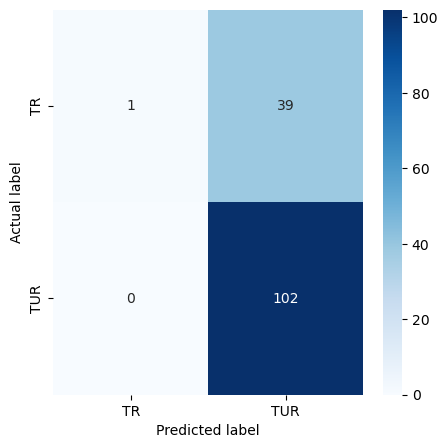

In [11]:
class_names = ['TR', 'TUR'] #['Task Related Thought', 'Task Unrelated Thought']
plt.figure(figsize=(5, 5))
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)

# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label') 
plt.xlabel('Predicted label', loc='center')
plt.show()

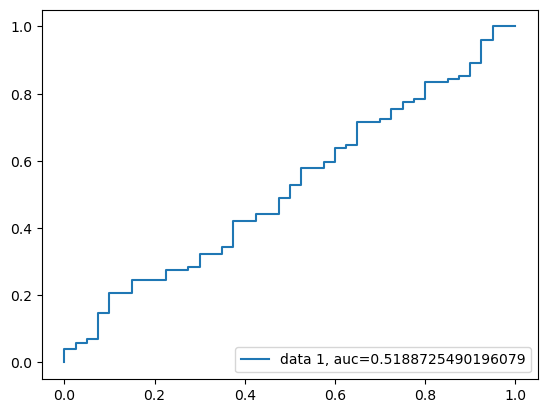

In [12]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# model = KNeighborsClassifier()
# model.fit(X_train, y_train)
# y_predict = model.predict(X_test)